In [302]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from dcegm.simulation.simulate import simulate
from dcegm.solve.solve import solve_retirement_model


%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
# Model parameter definitions

# Number of periods (fist period is t=1) 
Tbar = 25

# Number of grid points over assets
ngridm = 500

# Maximum level of assets
mmax = 50

# Number of quadrature points used in calculation of expectations
n_quad_points = 5

# Number of simulations
nsims = 50

# Interval of the initial wealth
init = [10, 30]

# Interest rate
r = 0.05

# Discount factor
beta = 0.95

# Standard deviation of log-normally distributed income shocks
sigma = 0.00

# Disutility of work
duw = 0.35

# CRRA coefficient (log utility if ==1)
theta = 1.95

# Careful with the coefficients here -- original code had the polynomial
# Coded as a + b * x - c * x**2 ... (note the crazy minus)
coeffs_age_poly = np.array([0.75, 0.04, -0.0002])

# Consumption floor (safety net in retirement)
cfloor = 0.001

# Scale of the EV taste shocks 
lambda_ = 2.2204e-16

Simulation
=========

In [283]:
# Solve model
value, policy = solve_retirement_model(
    ngridm, # name different in function and spec
    n_quad_points,
    r,
    coeffs_age_poly,
    theta,
    duw, # name different in function and spec
    beta,
    lambda_,
    sigma,
    mmax,
    Tbar, # name different in function and spec
    cfloor=0.001,
)

In [284]:
# Set seed
sim_seed = 7134 # figure out a way to ensure comparability in Python


# We have to set the seed!
#######################
np.random.seed(sim_seed)
########################

In [285]:
# Create containers
nsims = 10

In [286]:
wealth0 = np.full((nsims, Tbar), np.nan)
wealth1 = np.full((nsims, Tbar), np.nan)
consumption = np.full((nsims, Tbar), np.nan)
shock = np.full((nsims, Tbar), np.nan)
income_ = np.full((nsims, Tbar), np.nan)
worker = np.full((nsims, Tbar), np.nan)
prob_work = np.full((nsims, Tbar), np.nan)
retirement_age = np.full((nsims, 1), np.nan)

In [287]:
vl1 = np.full((2, nsims), np.nan)

In [288]:
# Period 0
it = 0

In [289]:
# Draw initial wealth
wealth0[:, it] = init[0] + np.random.uniform(0, 1, nsims)*(init[1]-init[0])

In [290]:
# Set status of all individuals (given by nsims) to working, i.e. 1
worker[:, it] = 1

In [291]:
# Fill in containers

# Next period value function
vl1[0, :] = value_function(0, it, wealth0[:, it], value, beta, theta, duw) # retirement
vl1[1, :] = value_function(1, it, wealth0[:, it], value, beta, theta, duw) # work

In [292]:
# Choice probability of working
prob_work[:, it] = choice_probabilities(vl1, lambda_)

In [293]:
# Record current period choice
working = (prob_work[:, it] > np.random.uniform(0, 1, nsims)).astype(int)

In [294]:
# Calculate current period consumption

period = it

cons10 = np.interp(
    wealth0[:, it], policy[period + 1][0].T[0], policy[period + 1][0].T[1]
)
# extrapolate linearly right of max grid point
slope = (policy[period + 1][0].T[1][-2] - policy[period + 1][0].T[1][-1]) / (
    policy[period + 1][0].T[0][-2] - policy[period + 1][0].T[0][-1]
)
intercept = policy[period + 1][0].T[1][-1] - policy[period + 1][0].T[0][-1] * slope
cons10[cons10 == np.max(policy[period + 1][0].T[1])] = (
    intercept + slope * wealth0[:, it][cons10 == np.max(policy[period + 1][0].T[1])]
)
cons10_flat = cons10.flatten("F")

cons11 = np.interp(
    wealth0[:, it], policy[period + 1][1].T[0], policy[period + 1][1].T[1]
)
# extrapolate linearly right of max grid point
slope = (policy[period + 1][1].T[1][-2] - policy[period + 1][1].T[1][-1]) / (
    policy[period + 1][1].T[0][-2] - policy[period + 1][1].T[0][-1]
)
intercept = policy[period + 1][1].T[1][-1] - policy[period + 1][1].T[0][-1] * slope
cons11[cons11 == np.max(policy[period + 1][1].T[1])] = (
    intercept + slope * wealth0[:, it][cons11 == np.max(policy[period + 1][1].T[1])]
)
cons11_flat = cons11.flatten("F")

In [295]:
consumption[:, it][working == 1] = cons11_flat[working == 1]
consumption[:, it][working == 0] = cons10_flat[working == 0]

In [296]:
wealth1[:, it] = wealth0[:, it] - consumption[:, it]

In [297]:
for it in range(1, Tbar-1):
    
    # Choice
    worker[:, it] = working 

    # Fill in retirement age
    retirement_age[(worker[:, it-1] == 1) & (worker[:, it] == 0)] = it

    # Shock, here no shock since set sigma = 0 for m0
    shock[:, it][worker[:, it] == 1] = norm.ppf(np.random.uniform(0,1, sum(working)))*sigma

    # Income
    income_[:, it] = 0
    income_[:, it][worker[:, it] == 1] = income(it, shock[:, it], coeffs_age_poly)[worker[:, it] == 1]

    # M_t+1
    # MatLab code should be equvalent to calculating correct income for workers and retired
    # and just adding savings times interest
    # No extra need for further differentiating between retired and working
    wealth0[:, it] = income_[:, it] + wealth1[:, it-1]*(1+r)


    # Next period value function
    vl1[0, :] = value_function(0, it, wealth0[:, it], value, beta, theta, duw) # retirement
    vl1[1, :] = value_function(1, it, wealth0[:, it], value, beta, theta, duw) # work

    # Choice probability of working
    prob_work[:, it] = choice_probabilities(vl1, lambda_)
    
    # Record current period choice
    working = (prob_work[:, it] > np.random.uniform(0, 1, nsims)).astype(int)
    # retirement is absorbing state or???
    ###############################
    working[ worker[:, it]==0] = 0.
    ###############################
    # Calculate current period consumption
    period = it

    cons10 = np.interp(
        wealth0[:, it], policy[period + 1][0].T[0], policy[period + 1][0].T[1]
    )
    # extrapolate linearly right of max grid point
    slope = (policy[period + 1][0].T[1][-2] - policy[period + 1][0].T[1][-1]) / (
        policy[period + 1][0].T[0][-2] - policy[period + 1][0].T[0][-1]
    )
    intercept = policy[period + 1][0].T[1][-1] - policy[period + 1][0].T[0][-1] * slope
    cons10[cons10 == np.max(policy[period + 1][0].T[1])] = (
        intercept + slope * wealth0[:, it][cons10 == np.max(policy[period + 1][0].T[1])]
    )
    cons10_flat = cons10.flatten("F")

    cons11 = np.interp(
        wealth0[:, it], policy[period + 1][1].T[0], policy[period + 1][1].T[1]
    )
    # extrapolate linearly right of max grid point
    slope = (policy[period + 1][1].T[1][-2] - policy[period + 1][1].T[1][-1]) / (
        policy[period + 1][1].T[0][-2] - policy[period + 1][1].T[0][-1]
    )
    intercept = policy[period + 1][1].T[1][-1] - policy[period + 1][1].T[0][-1] * slope
    cons11[cons11 == np.max(policy[period + 1][1].T[1])] = (
        intercept + slope * wealth0[:, it][cons11 == np.max(policy[period + 1][1].T[1])]
    )
    cons11_flat = cons11.flatten("F")

    consumption[:, it][working == 1] = cons11_flat[working == 1]
    consumption[:, it][working == 0] = cons10_flat[working == 0]

    wealth1[:, it] = wealth0[:, it] - consumption[:, it]

In [298]:
# Model parameter definitions

# Number of periods (fist period is t=1) 
num_periods = 25

# Number of grid points over assets
num_grid = 500

# Maximum level of assets
mmax = 50

# Number of quadrature points used in calculation of expectations
n_quad_points = 5

# Number of simulations
num_sims = 50

# Interval of the initial wealth
init = [10, 30]

# Interest rate
r = 0.05

# Discount factor
beta = 0.95

# Standard deviation of log-normally distributed income shocks
sigma = 0.00

# Disutility of work
cost_work = 0.35

# CRRA coefficient (log utility if ==1)
theta = 1.95

# Careful with the coefficients here -- original code had the polynomial
# Coded as a + b * x - c * x**2 ... (note the crazy minus)
coeffs_age_poly = np.array([0.75, 0.04, -0.0002])

# Consumption floor (safety net in retirement)
cfloor = 0.001

# Scale of the EV taste shocks 
lambda_ = 2.2204e-16

In [299]:
df = simulate(value, policy, num_periods, cost_work, theta, beta, lambda_, sigma, r,  coeffs_age_poly, num_sims=100)

In [300]:
df

wealth0    wealth1  consumption  working    income  \
identifier period                                                         
0          0       29.464230  25.364173     4.100057      1.0       NaN   
           1       31.122145  27.037576     4.084569      1.0  4.489763   
           2       33.022433  28.953775     4.068659      1.0  4.632979   
           3       35.180314  31.128022     4.052292      1.0  4.778850   
           4       37.611766  33.576336     4.035431      1.0  4.927344   
           5       40.333572  36.315541     4.018031      1.0  5.078419   
           6       43.363351  39.363311     4.000040      1.0  5.232033   
           7       46.719616  42.738218     3.981398      1.0  5.388139   
           8       44.875129  40.898839     3.976290      0.0  0.000000   
           9       42.943781  38.972591     3.971189      0.0  0.000000   
           10      40.921221  36.955126     3.966095      0.0  0.000000   
           11      38.802882  34.841875     3.961007      0.0  0.000000   
           12      36.583969  32.628043     3.955926      0.0  0.000000   
           13      34.259445  30.308594     3.950851      0.0  0.000000   
           14      31.824024  27.878241     3.945783      0.0  0.000000   
           15      29.272153  25.331432     3.940721      0.0  0.000000   
           16      26.598004  22.662338     3.935666      0.0  0.000000   
           17      23.795455  19.864838     3.930617      0.0  0.000000   
           18      20.858080  16.932506     3.925575      0.0  0.000000   
           19      17.779131  13.858592     3.920539      0.0  0.000000   
           20      14.551522  10.636013     3.915509      0.0  0.000000   
           21      11.167813   7.257327     3.910486      0.0  0.000000   
           22       7.620193   3.714724     3.905470      0.0  0.000000   
           23       3.900460   0.000000     3.900460      0.0  0.000000   
           24            NaN        NaN          NaN      NaN       NaN   
1          0       20.287703  16.035621     4.252082      1.0       NaN   
           1       21.327165  17.090766     4.236399      1.0  4.489763   
           2       22.578283  18.357989     4.220294      1.0  4.632979   
           3       24.054739  19.851006     4.203733      1.0  4.778850   
           4       25.770900  21.584223     4.186677      1.0  4.927344   
...                      ...        ...          ...      ...       ...   
98         20      18.304827  13.379382     4.925445      0.0  0.000000   
           21      14.048351   9.129225     4.919126      0.0  0.000000   
           22       9.585686   4.672870     4.912816      0.0  0.000000   
           23       4.906514   0.000000     4.906514      0.0  0.000000   
           24            NaN        NaN          NaN      NaN       NaN   
99         0       12.197543   7.766836     4.430707      1.0       NaN   
           1       12.644941   8.230146     4.414796      1.0  4.489763   
           2       13.274632   8.876170     4.398461      1.0  4.632979   
           3       14.098829   9.717158     4.381672      1.0  4.778850   
           4       15.130359  10.765971     4.364388      1.0  4.927344   
           5       16.382689  12.036123     4.346566      1.0  5.078419   
           6       17.869963  13.541809     4.328154      1.0  5.232033   
           7       19.607038  15.297948     4.309090      1.0  5.388139   
           8       21.609528  17.320224     4.289303      1.0  5.546682   
           9       23.893843  19.625139     4.268705      1.0  5.707608   
           10      26.477249  22.230060     4.247189      1.0  5.870853   
           11      29.377916  25.153293     4.224623      1.0  6.036353   
           12      32.614994  28.414150     4.200844      1.0  6.204036   
           13      36.208684  31.295051     4.913633      1.0  6.373827   
           14      39.405449  34.519664     4.885785      1.0  6.545645   
           15      36.245647  31.366130     4.

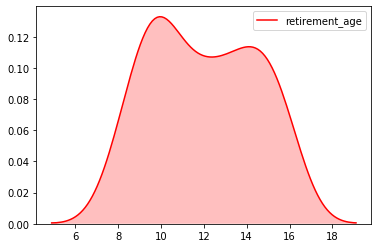

In [303]:
sns.kdeplot(df["retirement_age"].loc[:,0], shade=True, color="r")